In [8]:
from torch.utils.data import DataLoader
from data_analysis_utils import spher_to_cart
from data_analysis_utils import AlbumDataset
from data_analysis_utils import models
from data_analysis_utils import ModelEval
from pathlib import Path

checkpoints_path = Path('/data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/experiments/exp_RNO_four_2_1_0_linear_bn128_tr495_te124_lfn-MSELoss_opt-Adam_hiddenu-32_lr-0.001_lFactor-0.1_batchnorm-True_cartesian_transform-True/checkpoints')
checkpoint_path = Path('/data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/experiments/exp_RNO_four_2_1_0_linear_bn128_tr495_te124_lfn-MSELoss_opt-Adam_hiddenu-32_lr-0.001_lFactor-0.1_batchnorm-True_cartesian_transform-True/checkpoints/checkpoint_e947.pth')
album_path = '/data/i3store/users/ssued/albums/RNO_album_11_03_2025_20k_unorm/album_RNO4.hdf5'

# album_normalization_factor = [0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125]

album = AlbumDataset(album_path, transform = None, target_transform=spher_to_cart,normalize_labels=True,
                     normalization_factors=[0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125])
data_loader = DataLoader(dataset = album, batch_size = 1, shuffle = True)

test_model = models.RNO_four_2_1_0_linear(input_shape=1,
                          hidden_units=32,
                          normalize_inputs=True,
                          leak_factor=0.1,
                          output_shape=3,
                          num_epochs=1,
                          batch_size=1,
                          num_train_batches=1
                         )

model_results = ModelEval(test_model,album,data_loader,checkpoint_path=checkpoint_path,num_samples=500,store_images=True)

Setting coordinates to cartesian.
Utilizing inputted normalization statistics
  x: mean=0.4944, std=1230.7687
  y: mean=15.5359, std=1235.8513
  z: mean=-852.8795, std=445.8397
[0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125]
Calculating linear layer size using dummy shape: torch.Size([1, 1, 24, 1024, 4])
Flattened feature size: 9920
Creating Linear Layer: 9920 -> 3
Loading checkpoint: checkpoint_e947.pth...
Checkpoint Loaded!
Guesses and targets will be denormalized during processing.
Testing Model... (500/500 samples)


# Test what happens to the model if inputted a completely empty image

In [9]:
import torch

# Create a fake "empty" event
dummy_zero = torch.zeros((1, 1, 24, 1024, 4))

# Run model
with torch.no_grad():
    prediction = test_model(dummy_zero)

# Denormalize (model outputs Z-scores)
real_prediction = prediction
real_prediction = album.denormalize_label(prediction.cpu().numpy())

print("Model Output for Empty Input:", real_prediction)


# Inherent bias!!

# Model Output for Empty Input: tensor([[ 622.1123,  696.6857, -844.3330]])

Model Output for Empty Input: tensor([[ 622.1123,  696.6857, -844.3330]])


# X,Y,Z Unlearned Correlation Plot

This plot shows that the model gave up learning all dimensions (X,Y,Z) of an image, implying that the dimension has nothing to do with the model not learning, it is probably something to do with the image

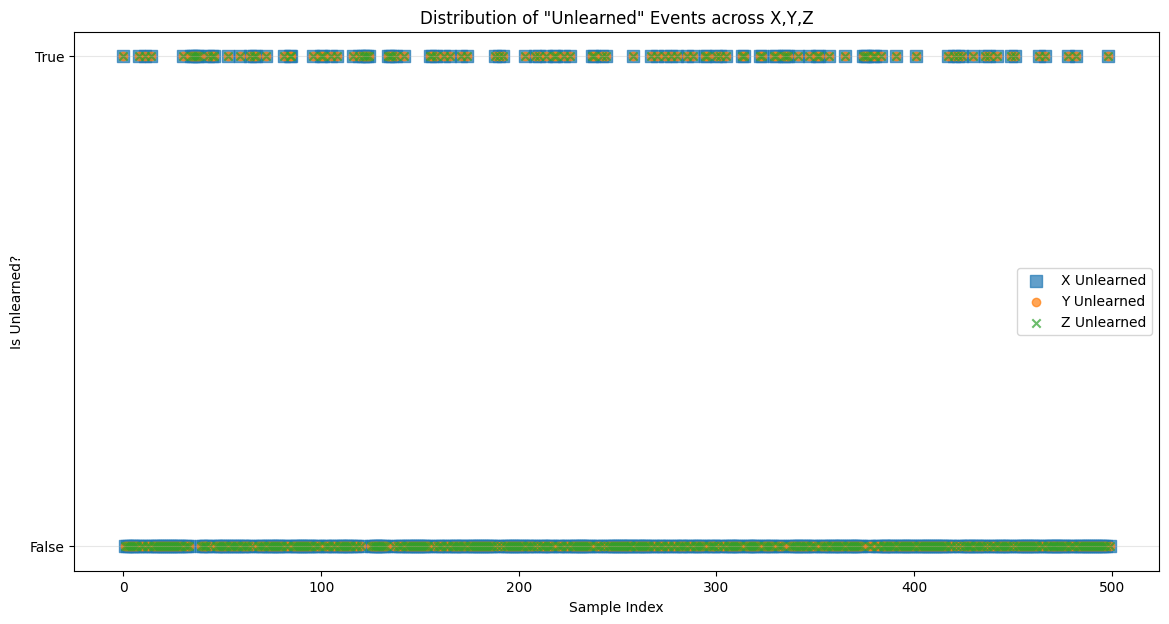

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure we are working with CPU numpy arrays
x = model_results.data_tensors.guess_arr[:,0].detach().cpu().numpy()
y = model_results.data_tensors.guess_arr[:,1].detach().cpu().numpy()
z = model_results.data_tensors.guess_arr[:,2].detach().cpu().numpy()

# Define boolean masks (True where the condition is met)
x_unlearned = (x < 623) & (x > 621)
y_unlearned = (y < 697) & (y > 696)
z_unlearned = (z < -843) & (z > -845)

plt.figure(figsize=(14, 7))

# Plot boolean values (False=0, True=1)
# Added alpha so you can see if markers overlap
plt.scatter(np.arange(len(x_unlearned)), x_unlearned, marker='s', label='X Unlearned', s=80, alpha=0.7)
plt.scatter(np.arange(len(y_unlearned)), y_unlearned, marker='o', label='Y Unlearned', alpha=0.7)
plt.scatter(np.arange(len(z_unlearned)), z_unlearned, marker='x', label='Z Unlearned', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Is Unlearned?')
plt.title('Distribution of "Unlearned" Events across X,Y,Z')

# FIX: plt.yticks takes two lists: [positions], [labels]
plt.yticks([0, 1], ['False', 'True'])

plt.legend(loc='center right')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Look at Max Voltage of unlearned parameters!

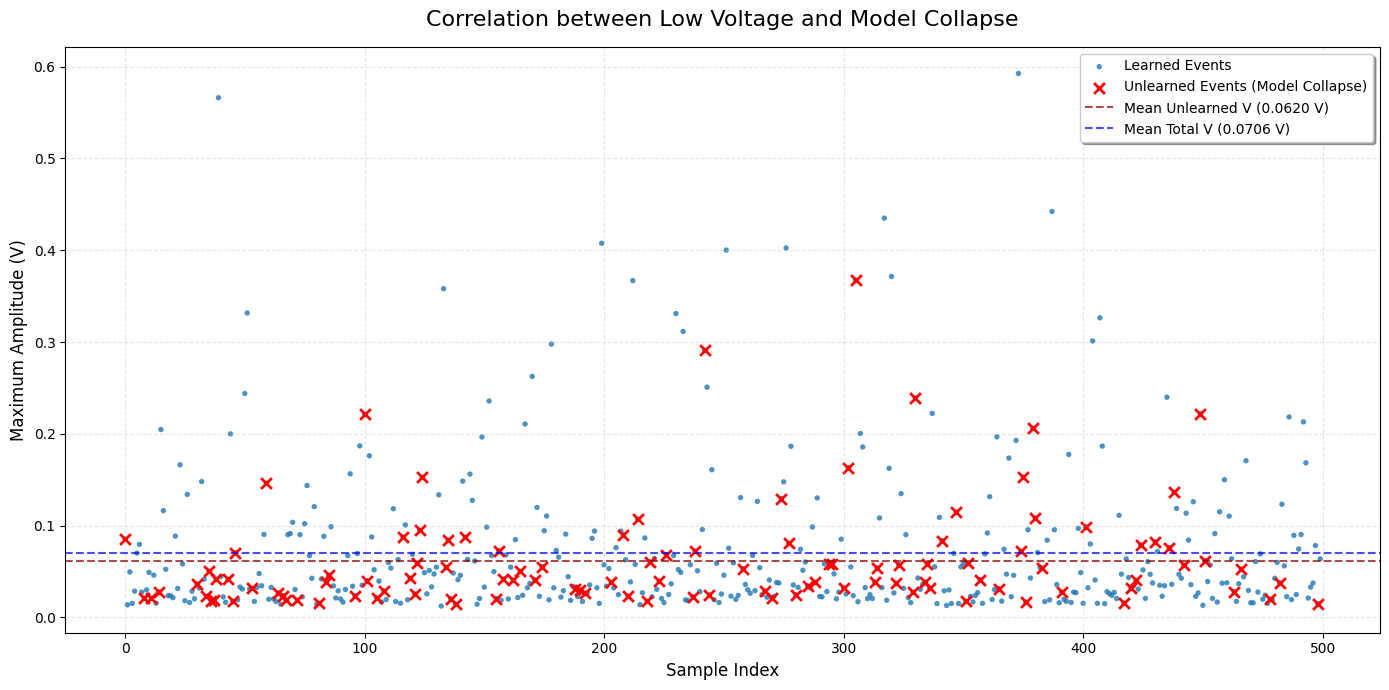

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_unlearned_voltage_analysis(model_results, x_unlearned):
    """
    Plots the max voltage of all events, highlighting the 'Unlearned' events.
    """
    # 1. Prepare Data
    # Convert list of images to a numpy array of max voltages
    max_v_arr = np.array([img.get_max_V() for img in model_results.data_tensors.image_arr])
    
    # Extract the 'Ghost' events using the boolean mask
    unlearned_max_v_arr = max_v_arr[x_unlearned]
    unlearned_indices = np.where(x_unlearned)[0]

    # Calculate stats for the label
    avg_unlearned_v = np.mean(unlearned_max_v_arr)
    avg_all_v = np.mean(max_v_arr)

    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 3. Plot Background (All Data)
    # Using scatter instead of plot to avoid "scribble" lines between arbitrary indices
    ax.scatter(np.arange(len(max_v_arr)), max_v_arr, 
               c='tab:blue', alpha=0.8, s=15, label='Learned Events', edgecolors='none')

    # 4. Plot Highlights (Unlearned Data)
    ax.scatter(unlearned_indices, unlearned_max_v_arr, 
               c='red', marker='x', s=60, lw=2, label='Unlearned Events (Model Collapse)')

    # 5. Add "Mean" Lines for visual comparison
    ax.axhline(avg_unlearned_v, color='darkred', linestyle='--', alpha=0.7, 
               label=f'Mean Unlearned V ({avg_unlearned_v:.4f} V)')
    ax.axhline(avg_all_v, color='blue', linestyle='--', alpha=0.7, 
               label=f'Mean Total V ({avg_all_v:.4f} V)')

    # 6. Formatting
    ax.set_title("Correlation between Low Voltage and Model Collapse", fontsize=16, pad=15)
    ax.set_xlabel("Sample Index", fontsize=12)
    ax.set_ylabel("Maximum Amplitude (V)", fontsize=12)
    ax.legend(loc='upper right', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Optional: Log scale if the difference is massive (e.g. 0.001 vs 1.0)
    # ax.set_yscale('log') 

    plt.tight_layout()
    plt.show()

    return unlearned_indices



# Usage (assuming your variables exist):
unlearned_indices = plot_unlearned_voltage_analysis(model_results, x_unlearned)

# Save Images and unlearned indices to take a closer look at them!

In [12]:
unlearned_indices+1

array([  1,   9,  12,  15,  31,  35,  36,  37,  38,  39,  44,  46,  47,
        54,  60,  65,  67,  68,  73,  82,  85,  86,  97, 101, 102, 106,
       109, 117, 120, 122, 123, 124, 125, 135, 136, 137, 139, 143, 156,
       157, 159, 163, 166, 172, 175, 189, 191, 193, 204, 209, 211, 215,
       219, 220, 224, 227, 238, 239, 243, 245, 259, 268, 271, 275, 278,
       281, 286, 289, 295, 296, 301, 303, 306, 314, 315, 323, 324, 330,
       331, 335, 336, 337, 342, 348, 352, 353, 358, 366, 375, 376, 377,
       380, 381, 384, 392, 402, 418, 421, 423, 425, 431, 437, 439, 443,
       450, 452, 464, 467, 479, 483, 499])

In [13]:
for idx, image in enumerate(model_results.data_tensors.image_arr):
    image.plot_image(save_path=Path(f'/data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image{idx+1}'))

Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image1
Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image2
Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image3
Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image4
Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/data_analysis/images/image5
Saving image to: /data/condor_shared/users/ssued/RNOG_Image_Builder/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartes

# Progression plots

Can only do if a directory was given to `ModelEval`

Found 19 checkpoints to evaluate.

--- Evaluating Checkpoint: checkpoint_e50.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (500/500 samples)


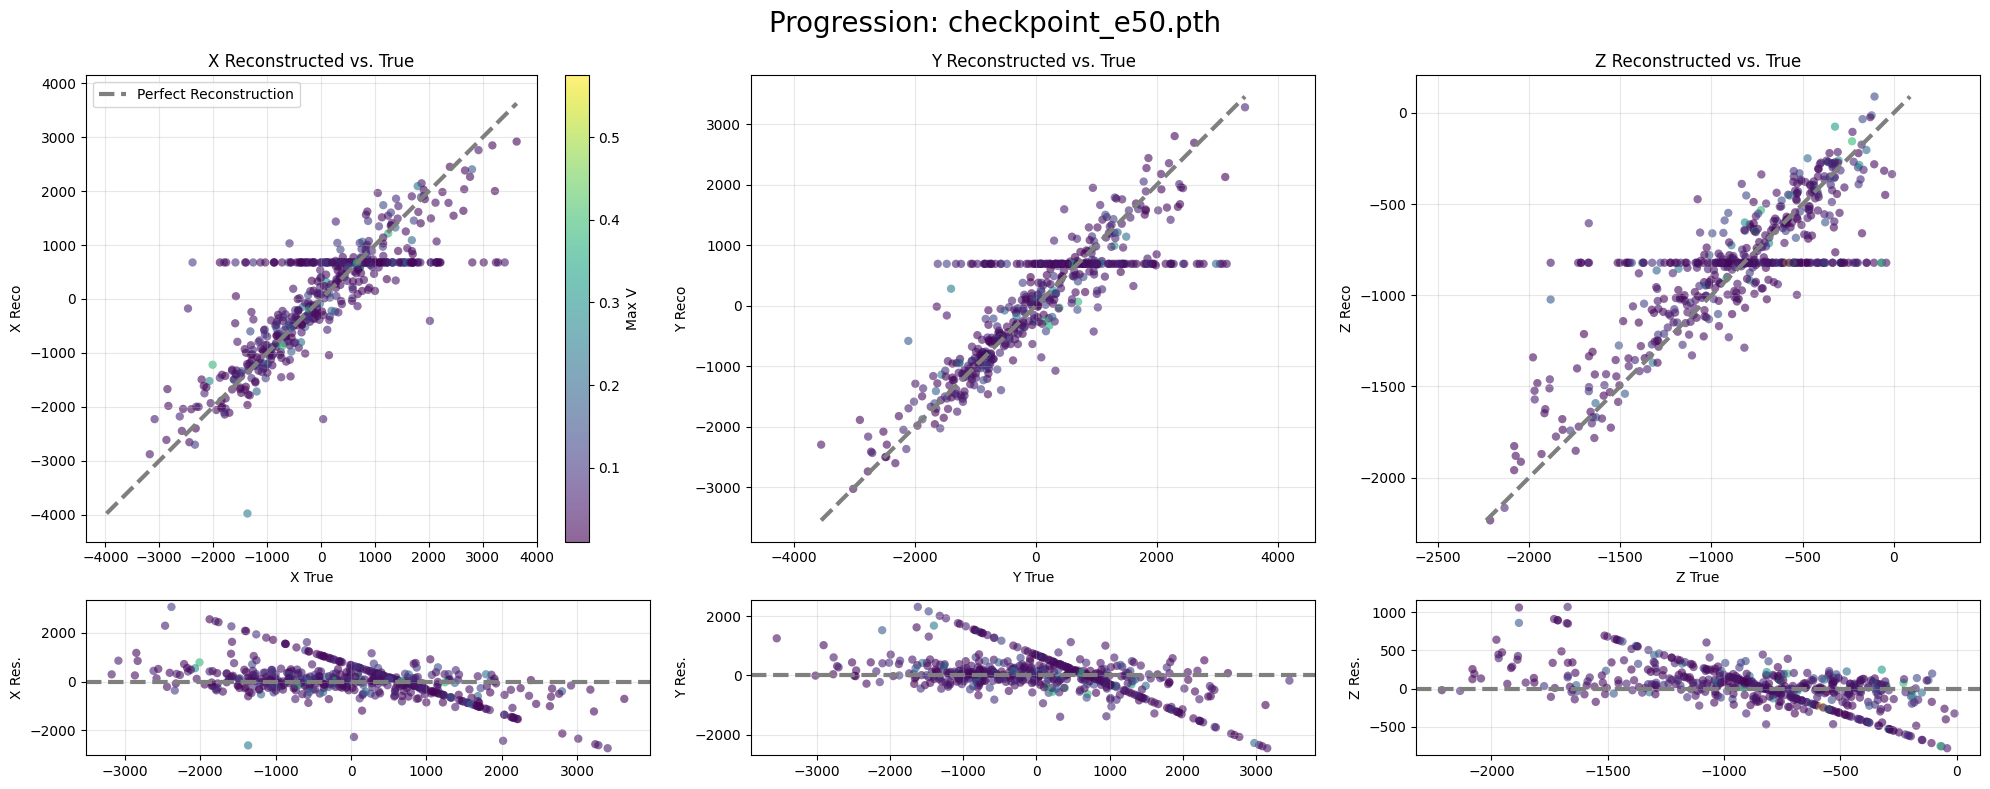


--- Evaluating Checkpoint: checkpoint_e100.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (29/500 samples)

KeyboardInterrupt: 

In [15]:
model_results.plot_progression_true_reco(spherical=False,show_maxV=True)